# Subpocket center robustness

We aim for robust subpocket centers, in order to calculate comparable subpocket distances across kinase structures.

- Mean/standard deviation for centers between and across subpockets
- Superimpose random structures with their subpocket centers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote
from opencadd.structure.pocket import PocketKlifs, PocketViewer

from kissim.definitions import ANCHOR_RESIDUES
from kissim.encoding import FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"
RESULTS = HERE / "../../results/"

In [5]:
REMOTE = setup_remote()

## Mean/standard deviation for centers between and across subpockets

### Load fingerprints

Let's load our pre-calculated fingerprint saved in a _json_ file as `FingerprintGenerator` object.

In [6]:
print(RESULTS / "fingerprints.json")

/home/dominique/Documents/GitHub/kissim_app/notebooks/subpockets/../../results/fingerprints.json


In [7]:
fingerprint_generator = FingerprintGenerator.from_json(
    RESULTS / "fingerprints.json", normalize=True
)
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4918


In [8]:
fingerprint_generator.subpocket_centers

subpocket    center                       dfg_region                        \
dimension         x          y          z          x          y          z   
3835       1.023518  20.786118  36.407101   7.406333  20.055666  33.521999   
6679       1.047812  21.004131  36.159405   7.346666  20.813665  33.243668   
7156       1.255835  20.998943  36.523186   7.520000  20.843000  33.730000   
1104       1.255529  20.852882  36.860538   8.527667  21.796333  34.455334   
1065       0.760482  21.739023  36.460827   7.521334  23.108002  32.718002   
...             ...        ...        ...        ...        ...        ...   
1849       1.100906  21.125095  36.784340   7.378334  21.109335  34.070999   
1850       1.241941  21.068130  37.049435   7.758667  20.841333  34.701332   
1847       1.137012  21.019848  36.848209   7.400667  20.911665  34.196667   
7218       0.460841  21.238731  36.969425   7.463000  21.249666  34.302670   
7219       0.650437  21.145950  37.116161   8.445666  22.603998  34.847000   

subpocket front_pocket                       hinge_region             \
dimension            x          y          z            x          y   
3835         -0.281000  16.146334  39.322002     1.975000  21.757334   
6679          0.057667  16.356667  38.983334     2.009333  21.944666   
7156          0.278333  16.515665  39.410000     2.069000  22.047003   
1104          0.116000  16.389999  39.197330     2.066000  21.873001   
1065          0.780667  17.596666  38.630333     1.707667  23.181999   
...                ...        ...        ...          ...        ...   
1849          0.737667  16.547333  39.517334     2.239667  22.255667   
1850          0.536333  16.622667  39.852333     2.221334  22.268333   
1847          0.702000  16.519667  39.630329     2.176000  22.093332   
7218          0.387000  16.674000  39.379333     2.058333  22.553665   
7219          0.248667  16.351334  39.368999     2.245000  22.417999   

subpocket             
dimension          z  
3835       41.807003  
6679       41.545666  
7156       41.866333  
1104       41.794666  
1065       40.907669  
...              ...  
1849       42.347668  
1850       42.421001  
1847       42.294666  
7218       42.360996  
7219       42.335667  

[4918 rows x 12 columns]

### Load KLIFS reference PDB IDs

Load KLIFS reference structures and add structure KLIFS IDs.

In [9]:
# Get KLIFS reference structures
klifs_reference_structures = pd.read_csv(
    DATA / "external" / "klifs_reference_structures.csv", delimiter=";"
)
klifs_reference_structures["structure.pdb_id"] = klifs_reference_structures[
    "structure.pdb_id"
].apply(lambda x: x.lower())
# Get metadata for these reference structures from KLIFS remote
structures = REMOTE.structures.by_structure_pdb_id(
    klifs_reference_structures["structure.pdb_id"].to_list()
)
structures = structures[
    ["structure.klifs_id", "structure.pdb_id", "structure.chain", "structure.alternate_model"]
]
# Merge information
klifs_reference_structures = klifs_reference_structures.merge(
    structures, how="left", on=["structure.pdb_id", "structure.chain", "structure.alternate_model"]
)
klifs_reference_structures

,kinase.group,kinase.klifs_name,structure.pdb_id,structure.chain,structure.alternate_model,ligand.name,structure.klifs_id
0,AGC,ROCK1,3d9v,A,-,H-1152P,2696
1,AGC,AKT2,3d0e,A,-,GSK690693,1912
2,AGC,PDK1,1uu3,A,A,LY333531,3180
3,CAMK,LCK,1qpd,A,-,Staurosporine,2267
4,CAMK,PHKg2,2y7j,A,A,Sunitinib,1894
5,CAMK,DAPK1,1wvx,A,-,BDB402,5616
6,CK1,CK1g3,2izs,A,A,4-amino-2-((3-chlorophenyl)amino)-5-(4-fluorob...,2228
7,CK1,CK1g1,2cmw,A,A,2-(2-hydroxyethylamino)-6-(3-chloroanilino)-9-...,5567
8,CK1,CK1g3,2chl,A,A,"5-amino-N-(2,6-difluorophenyl)-3-((4-sulfamoyl...",2220
9,CMGC,GSK3B,3zrm,A,A,"7-(4-hydroxyphenyl)-2-(pyridin-4-yl)thieno[3,2...",751


Remove reference structures that are not part of our dataset.

In [10]:
klifs_reference_structures = klifs_reference_structures[
    klifs_reference_structures["structure.klifs_id"].isin(list(fingerprint_generator.data.keys()))
].reset_index()
klifs_reference_structures

,index,kinase.group,kinase.klifs_name,structure.pdb_id,structure.chain,structure.alternate_model,ligand.name,structure.klifs_id
0,1,AGC,AKT2,3d0e,A,-,GSK690693,1912
1,3,CAMK,LCK,1qpd,A,-,Staurosporine,2267
2,5,CAMK,DAPK1,1wvx,A,-,BDB402,5616
3,6,CK1,CK1g3,2izs,A,A,4-amino-2-((3-chlorophenyl)amino)-5-(4-fluorob...,2228
4,7,CK1,CK1g1,2cmw,A,A,2-(2-hydroxyethylamino)-6-(3-chloroanilino)-9-...,5567
5,8,CK1,CK1g3,2chl,A,A,"5-amino-N-(2,6-difluorophenyl)-3-((4-sulfamoyl...",2220
6,12,Other,TTK,3gfw,A,-,Mps1-IN-1,4714
7,13,Other,AurA,2xru,A,-,PHA-828300,1954
8,14,Other,Wee1,1x8b,A,-,PD0407824,209
9,15,STE,MST3,3a7i,A,-,Adenine,5611


### Inter-subpocket distances within each structure

In [11]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_names = subpocket_centers.columns.get_level_values("subpocket").unique()
subpocket_pairs = itertools.combinations(subpocket_names, 2)
distances = {}
for subpocket_pair in subpocket_pairs:
    difference = subpocket_centers[subpocket_pair[0]] - subpocket_centers[subpocket_pair[1]]
    distance = difference.dropna().apply(lambda x: np.linalg.norm(x), axis=1)
    distances[subpocket_pair] = distance
distances = pd.DataFrame(distances)
distances

center                             dfg_region               \
      dfg_region front_pocket hinge_region front_pocket hinge_region   
1       7.327429     5.321845     4.729283     9.883736     9.469565   
2       7.090676     5.594592     5.014029    10.062895     9.464422   
8       7.581782     5.576537     5.109358    10.715704    10.248727   
11      7.647271     5.563454     5.210495    11.136788    10.732556   
15      8.087461     6.247401     5.237044    12.601992    11.174454   
...          ...          ...          ...          ...          ...   
13029   7.343659     5.925618     5.563868    11.414586    10.459132   
13034   7.967823     5.242968     5.304604    10.864191    10.287338   
13035   7.349428     5.903395     5.506401    11.380352    10.376052   
13037   6.616313     5.213832     5.603139     9.213518     9.374709   
13039   6.678425     5.359182     5.773842     9.444947     9.680273   

      front_pocket  
      hinge_region  
1         6.086583  
2         6.407095  
8         6.489513  
11        6.367466  
15        6.477832  
...            ...  
13029     6.415950  
13034     6.476519  
13035     6.433025  
13037     6.932446  
13039     7.096647  

[4916 rows x 6 columns]

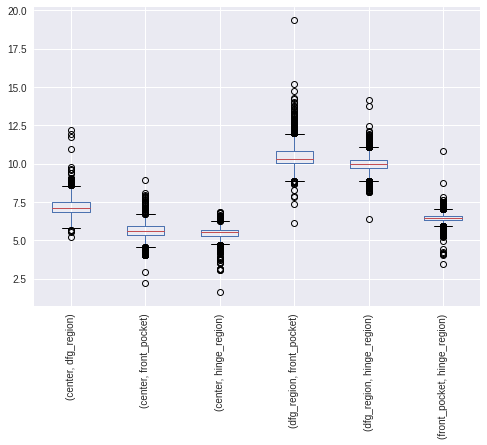

In [12]:
distances.plot(kind="box", rot=90);

In [13]:
distances_stats = pd.concat([distances.std(), distances.mean()], axis=1)
distances_stats.columns = ["std", "mean"]
distances_stats

std       mean
center       dfg_region    0.510658   7.180568
             front_pocket  0.481920   5.632029
             hinge_region  0.350902   5.493497
dfg_region   front_pocket  0.845593  10.547420
             hinge_region  0.573776  10.024942
front_pocket hinge_region  0.324889   6.433326

In [14]:
distances_stats = distances_stats.reset_index()

distances_stats_1 = distances_stats.copy()
distances_stats_1 = distances_stats_1.rename(
    columns={"level_0": "subpocket 1", "level_1": "subpocket 2"}
)
distances_stats_2 = distances_stats.copy()
distances_stats_2 = distances_stats_2.rename(
    columns={"level_1": "subpocket 1", "level_0": "subpocket 2"}
)

distances_stats = pd.concat([distances_stats_1, distances_stats_2])
distances_stats

,subpocket 1,subpocket 2,std,mean
0,center,dfg_region,0.510658,7.180568
1,center,front_pocket,0.481920,5.632029
2,center,hinge_region,0.350902,5.493497
3,dfg_region,front_pocket,0.845593,10.547420
4,dfg_region,hinge_region,0.573776,10.024942
5,front_pocket,hinge_region,0.324889,6.433326
0,dfg_region,center,0.510658,7.180568
1,front_pocket,center,0.481920,5.632029
2,hinge_region,center,0.350902,5.493497
3,front_pocket,dfg_region,0.845593,10.547420


### Intra-subpocket distances to reference structure

In [15]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_names = subpocket_centers.columns.get_level_values("subpocket").unique()
structure_klifs_ids = klifs_reference_structures["structure.klifs_id"].to_list()

distances = {}

for subpocket_name in subpocket_names:
    distances[subpocket_name] = {}
    for structure_klifs_id in structure_klifs_ids:
        a = subpocket_centers[subpocket_name].drop(structure_klifs_id)
        b = subpocket_centers[subpocket_name].loc[structure_klifs_id, :]
        difference = a - b
        distance = difference.dropna().apply(lambda x: np.linalg.norm(x), axis=1)
        distances[subpocket_name][structure_klifs_id] = distance
    distances[subpocket_name] = pd.DataFrame(distances[subpocket_name])

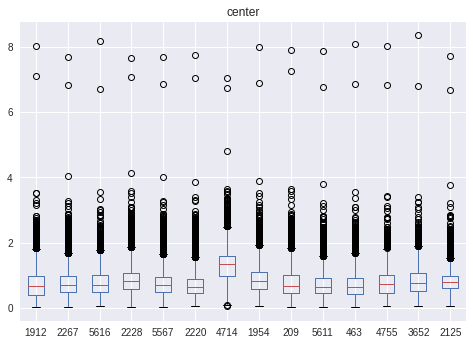

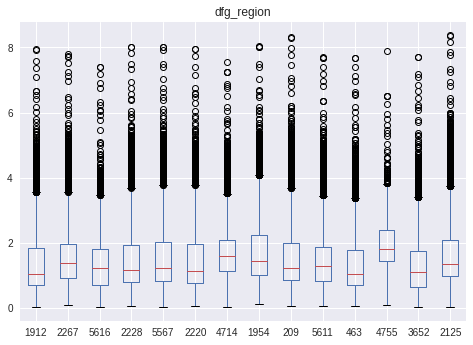

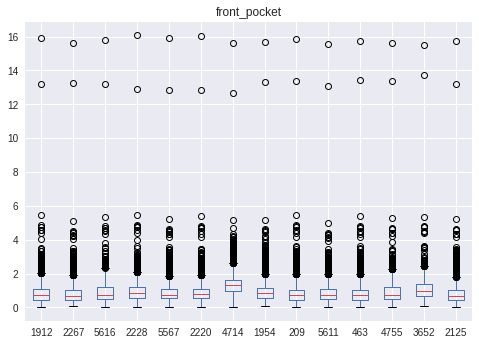

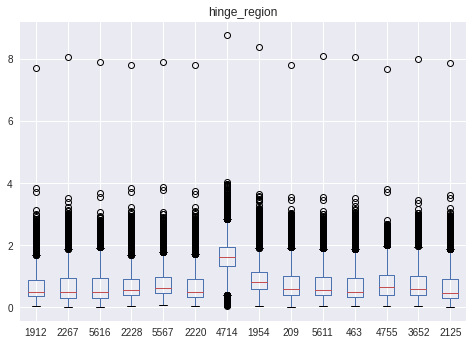

In [16]:
for subpocket_name in subpocket_names:
    distances[subpocket_name].plot(kind="box", title=subpocket_name)

In [17]:
# Get mean of each reference structure's std
distances_stats_intra = []
for subpocket_name in subpocket_names:
    distance_std = distances[subpocket_name].std().mean()
    distance_mean = distances[subpocket_name].mean().mean()
    distances_stats_intra.append([subpocket_name, subpocket_name, distance_std, distance_mean])
distances_stats_intra = pd.DataFrame(
    distances_stats_intra, columns=["subpocket 1", "subpocket 2", "std", "mean"]
)

### Heatmap for inter- and intra-subpocket distances (mean/std)

In [18]:
distances_stats = pd.concat([distances_stats, distances_stats_intra]).reset_index(drop=True)
distances_stats

,subpocket 1,subpocket 2,std,mean
0,center,dfg_region,0.510658,7.180568
1,center,front_pocket,0.481920,5.632029
2,center,hinge_region,0.350902,5.493497
3,dfg_region,front_pocket,0.845593,10.547420
4,dfg_region,hinge_region,0.573776,10.024942
5,front_pocket,hinge_region,0.324889,6.433326
6,dfg_region,center,0.510658,7.180568
7,front_pocket,center,0.481920,5.632029
8,hinge_region,center,0.350902,5.493497
9,front_pocket,dfg_region,0.845593,10.547420


In [19]:
distances_std_pivot = distances_stats.drop("mean", axis=1).pivot(
    columns="subpocket 1", index="subpocket 2", values="std"
)
distances_std_pivot

subpocket 1,center,dfg_region,front_pocket,hinge_region
subpocket 2,,,,
center,0.455354,0.510658,0.481920,0.350902
dfg_region,0.510658,0.997210,0.845593,0.573776
front_pocket,0.481920,0.845593,0.650957,0.324889
hinge_region,0.350902,0.573776,0.324889,0.603697


In [20]:
distances_mean_pivot = distances_stats.drop("std", axis=1).pivot(
    columns="subpocket 1", index="subpocket 2", values="mean"
)
# Reverse column names to that they overlay with the heatmap
reversed_column_names = distances_mean_pivot.columns.to_list()[::-1]
distances_mean_pivot = distances_mean_pivot.loc[reversed_column_names, reversed_column_names]
distances_mean_pivot

subpocket 1,hinge_region,front_pocket,dfg_region,center
subpocket 2,,,,
hinge_region,0.845879,6.433326,10.024942,5.493497
front_pocket,6.433326,0.956004,10.547420,5.632029
dfg_region,10.024942,10.547420,1.557430,7.180568
center,5.493497,5.632029,7.180568,0.827927


Text(51.0, 0.5, '')

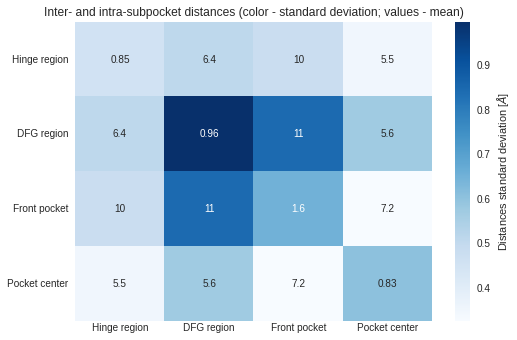

In [21]:
sns.heatmap(
    distances_std_pivot,
    cmap="Blues",
    annot=distances_mean_pivot,
    cbar_kws={"label": "Distances standard deviation [$\AA$]"},  # noqa: W605
)
labels = ["Hinge region", "DFG region", "Front pocket", "Pocket center"]
plt.title("Inter- and intra-subpocket distances (color - standard deviation; values - mean)")
plt.xticks(np.arange(4) + 0.5, (labels), rotation=0, va="center")
plt.yticks(np.arange(4) + 0.5, (labels), rotation=0, va="center")
plt.xlabel("")
plt.ylabel("")
# sns.set(font_scale=2)

Key takeaways:

- Distance mean
  - Pocket center, hinge region, and front pocket are about equally spaced from each other (~6A)
  - DFG region is a bit further away (closer to pocket center than to hinge region and front pocket)
- Distance standard deviation
  - Standard deviations are all below 1A
  - DFG subpocket shows most variation (w.r.t. DFG conformations), followed by the front pocket (w.r.t. flexible p-loop)


### Show example structure with subpockets

Let's show an example structure with subpockets to make sense of the mean distances that we have calculated.

In [22]:
subpockets = {
    "anchor_residue.klifs_ids": list(ANCHOR_RESIDUES.values()),
    "subpocket.name": list(ANCHOR_RESIDUES.keys()),
    "subpocket.color": ["magenta", "cyan", "green"],
}
subpockets

{'anchor_residue.klifs_ids': [[16, 47, 80], [19, 24, 81], [10, 48, 72]],
 'subpocket.name': ['hinge_region', 'dfg_region', 'front_pocket'],
 'subpocket.color': ['magenta', 'cyan', 'green']}

In [23]:
pocket = PocketKlifs.from_structure_klifs_id(3652, subpockets)

In [24]:
subpocket_coords = (
    pocket.subpockets[["subpocket.name", "subpocket.center"]].set_index("subpocket.name").squeeze()
)
subpocket_coords = pd.concat(
    [subpocket_coords, pd.Series([pocket.center.tolist()], index=["center"])]
)

distances_example_structure = {}
subpocket_pairs = itertools.combinations(subpocket_coords.index, 2)
for subpocket_pair in subpocket_pairs:
    difference = subpocket_coords[subpocket_pair[0]] - subpocket_coords[subpocket_pair[1]]
    distance = np.linalg.norm(difference)
    distances_example_structure[subpocket_pair] = distance
distances_example_structure

{('hinge_region', 'dfg_region'): 9.955494,
 ('hinge_region', 'front_pocket'): 6.3870726,
 ('hinge_region', 'center'): 5.538795222621422,
 ('dfg_region', 'front_pocket'): 10.053213,
 ('dfg_region', 'center'): 7.183169918155383,
 ('front_pocket', 'center'): 5.249160890296896}

In [26]:
viewer = PocketViewer()
viewer.add_pocket(pocket)
viewer.viewer

NGLWidget()

In [27]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

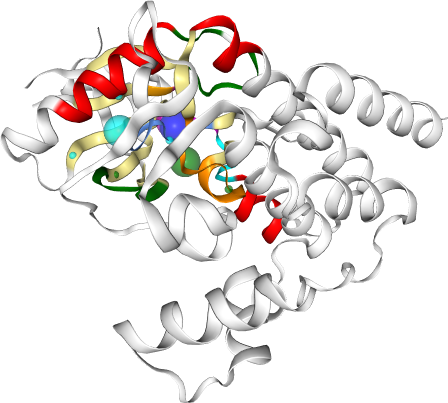

In [28]:
viewer.viewer._display_image()

## Superimpose random structures with their subpocket centers

In [29]:
N_RANDOM_STRUCTURES = 20

In [30]:
SUBPOCKETS = {
    "anchor_residue.klifs_ids": list(ANCHOR_RESIDUES.values()),
    "subpocket.name": list(ANCHOR_RESIDUES.keys()),
    "subpocket.color": ["magenta", "cyan", "green"],
}
SUBPOCKETS

{'anchor_residue.klifs_ids': [[16, 47, 80], [19, 24, 81], [10, 48, 72]],
 'subpocket.name': ['hinge_region', 'dfg_region', 'front_pocket'],
 'subpocket.color': ['magenta', 'cyan', 'green']}

In [31]:
structure_klifs_ids = fingerprint_generator.data.keys()
structure_klifs_ids_random = random.sample(structure_klifs_ids, N_RANDOM_STRUCTURES)

In [40]:
viewer = PocketViewer()
for structure_klifs_id in structure_klifs_ids_random:
    pocket = PocketKlifs.from_structure_klifs_id(structure_klifs_id, SUBPOCKETS)
    viewer.add_pocket(pocket, show_only_pocket_residues=True)
viewer.viewer.display(gui=True)

NGLWidget(gui_style='ngl')

In [34]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

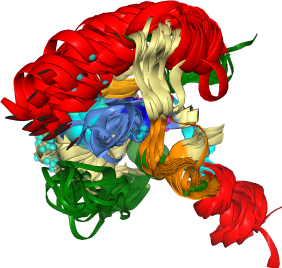

In [35]:
viewer.viewer._display_image()

In [36]:
viewer = PocketViewer()
for structure_klifs_id in structure_klifs_ids_random:

    pocket = PocketKlifs.from_structure_klifs_id(structure_klifs_id, SUBPOCKETS)

    viewer.add_pocket(pocket, show_only_pocket_residues=True)
    component_ix = viewer._components_structures[structure_klifs_id]
    selection = " or ".join(viewer.pockets_residue_ngl_ixs[pocket.name])

    viewer.viewer.clear_representations(component_ix)
    viewer.viewer.add_representation(
        "cartoon", selection=selection, component=component_ix, opacity=0.1
    )
viewer.viewer.display(gui=True)

KeyboardInterrupt: 

In [ ]:
viewer.viewer.render_image(trim=True, factor=1, transparent=True);

In [ ]:
viewer.viewer._display_image()